处理后的OrderBook数据结构：
    timestamp  level_1  ask_price_1  ask_volume_1  bid_price_1  bid_volume_1  \
0  1743782415        0     118.7450          44.0      118.930           1.0   
1  1743782435        0     118.8810         367.1      118.870           3.8   
2  1743782455        0     118.5780          19.4      118.548          12.2   
3  1743782475        0     118.6667          19.0      118.819         846.5   
4  1743782495        0     118.7600           3.8      118.749         792.5   

   ask_price_2  ask_volume_2  bid_price_2  bid_volume_2  ...  bid_volume_8  \
0       118.79          38.0      118.859        1131.2  ...           NaN   
1          NaN           NaN          NaN           NaN  ...           NaN   
2          NaN           NaN          NaN           NaN  ...           NaN   
3       118.69          73.0      118.800        1329.3  ...           NaN   
4          NaN           NaN          NaN           NaN  ...           NaN   

   ask_price_9  ask_volume_9  b

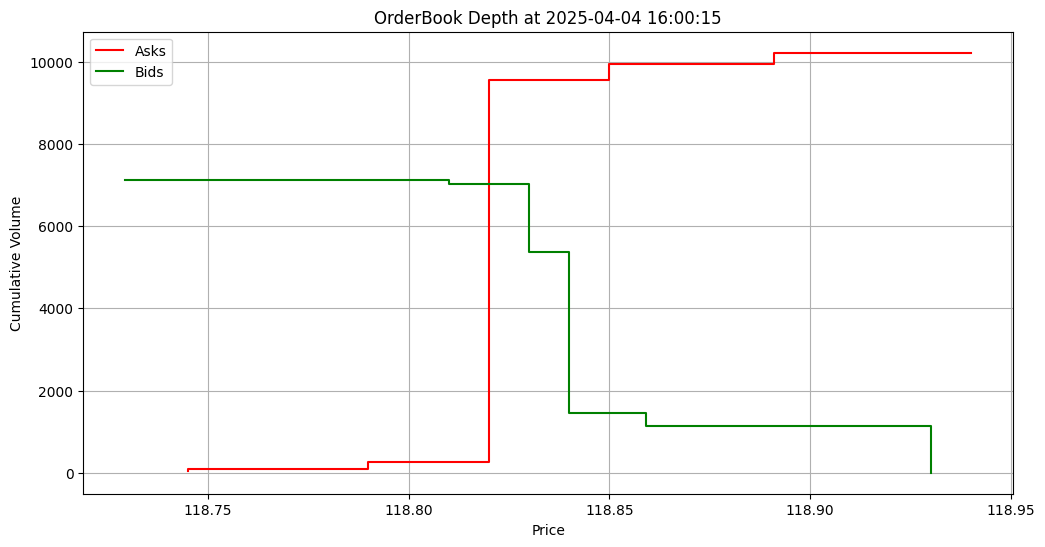

In [14]:
#从bybit获取L2免费数据
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

data_path = "/Users/jacek/Desktop/Python写的代码/quant_k/多因子策略/data/20250405/20250405.xlsx"

# 读取数据
df = pd.read_excel(data_path)

# 将时间戳转换为datetime格式
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# 按时间戳分组处理数据
def process_orderbook(group):
    # 分别处理买卖盘
    asks = pd.DataFrame({
        'price': group['ask_price'],
        'volume': group['ask_volume']
    }).sort_values('price')  # 卖盘按价格升序
    
    bids = pd.DataFrame({
        'price': group['bid_price'],
        'volume': group['bid_volume']
    }).sort_values('price', ascending=False)  # 买盘按价格降序
    
    # 取前10档
    asks = asks.head(10)
    bids = bids.head(10)
    
    # 构建结果
    result = pd.DataFrame()
    for i in range(10):
        if i < len(asks):
            result[f'ask_price_{i+1}'] = [asks.iloc[i]['price']]
            result[f'ask_volume_{i+1}'] = [asks.iloc[i]['volume']]
        else:
            result[f'ask_price_{i+1}'] = [np.nan]
            result[f'ask_volume_{i+1}'] = [np.nan]
            
        if i < len(bids):
            result[f'bid_price_{i+1}'] = [bids.iloc[i]['price']]
            result[f'bid_volume_{i+1}'] = [bids.iloc[i]['volume']]
        else:
            result[f'bid_price_{i+1}'] = [np.nan]
            result[f'bid_volume_{i+1}'] = [np.nan]
    
    return result

# 按时间戳分组重构OrderBook
orderbook_df = df.groupby('timestamp').apply(process_orderbook).reset_index()
orderbook_df['datetime'] = pd.to_datetime(orderbook_df['timestamp'], unit='s')

# 按时间排序
orderbook_df = orderbook_df.sort_values('timestamp')

# 展示处理后的数据
print("处理后的OrderBook数据结构：")
print(orderbook_df.head())

# 计算买卖盘价差
orderbook_df['spread'] = orderbook_df['ask_price_1'] - orderbook_df['bid_price_1']

# 基础统计信息
print("\n基础统计信息：")
print(f"平均价差: {orderbook_df['spread'].mean():.6f}")
print(f"最大价差: {orderbook_df['spread'].max():.6f}")
print(f"最小价差: {orderbook_df['spread'].min():.6f}")

# 可视化买卖盘深度
def plot_orderbook_depth(snapshot):
    plt.figure(figsize=(12, 6))
    
    # 获取买卖盘价格和数量
    ask_prices = [snapshot[f'ask_price_{i}'] for i in range(1, 11) if not pd.isna(snapshot[f'ask_price_{i}'])]
    ask_volumes = [snapshot[f'ask_volume_{i}'] for i in range(1, 11) if not pd.isna(snapshot[f'ask_volume_{i}'])]
    bid_prices = [snapshot[f'bid_price_{i}'] for i in range(1, 11) if not pd.isna(snapshot[f'bid_price_{i}'])]
    bid_volumes = [snapshot[f'bid_volume_{i}'] for i in range(1, 11) if not pd.isna(snapshot[f'bid_volume_{i}'])]
    
    plt.step(ask_prices, np.cumsum(ask_volumes), 'r-', label='Asks')
    plt.step(bid_prices, np.cumsum(bid_volumes), 'g-', label='Bids')
    
    plt.title(f'OrderBook Depth at {snapshot["datetime"]}')
    plt.xlabel('Price')
    plt.ylabel('Cumulative Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

# 绘制第一个时间点的订单簿深度图
plot_orderbook_depth(orderbook_df.iloc[0])

In [13]:
reconstructed_df

0        1.743782e+09
1        1.187450e+02
2        4.400000e+01
3        1.189300e+02
4        1.000000e+00
             ...     
56344    1.743869e+09
56345    1.175080e+02
56346    2.240000e+02
56347    1.175040e+02
56348    2.970000e+01
Length: 56349, dtype: float64